# Visualization and segmentation for merfish data
Thomas Defard 29/01/2024

In [1]:
import pandas as pd 
import numpy as np
from pathlib import Path
import json
from tqdm import tqdm
import tifffile
import matplotlib.pyplot as plt

**To install a package do ``pip install name_of_package `` in your terminal**

best practice  :  use a conda environnement https://conda.io/projects/conda/en/latest/user-guide/getting-started.html  

To use a conda env in a notebook apply this tutorial : https://medium.com/@nrk25693/how-to-add-your-conda-environment-to-your-jupyter-notebook-in-just-4-steps-abeab8b8d084

# visualization of the entire slide


You can visualize you data with TissUUmaps (https://tissuumaps.github.io/installation/ ), a software design for very large image
Once it is install, do ``$ tissuumaps`` in your terminal and you can drop images in it and you get this images : 

<img src="img_notebook/all_tissue.png" alt="drawing" width="50%"/>

To vizualise the RNA spots you can drop ``detected_transcript.csv`` in tissuumaps but the rna spots are not alligned with the images so you will get an images like below. 
Also, the spot coordiantes are in µm and not in pixel. You have to put 1/0.108 = 9.259 in the "scale" option to get it in pixel.

You can aslo vizualised the position of the cell detected by MERSPCOPE with the file ``cell_metadata.csv``

<img src="img_notebook/spots1.png" alt="drawing" width="50%"/>

To register the spots with this images you have to use the "manifest.json" file 

In [2]:
##### TO COMPLETE WITH YOUR PATH

path_to_region = "/media/tom/Transcend/bioinfo-portal.curie.fr/backend/services/popeye/2018383/output/region_1"
path_to_save_csv_rna = path_to_region + "/rna_z_stack1"

# create the folder to save the registered CSV
Path(path_to_save_csv_rna).mkdir(parents=True, exist_ok=True)

In [7]:

f = open(path_to_region + "/images/manifest.json")
manifest = json.load(f)

x_off_set_microns = manifest['bbox_microns'][0]
y_off_set_microns = manifest['bbox_microns'][1]

### register the csv
csv = pd.read_csv(path_to_region + "/detected_transcripts.csv")
csv["global_x"] = csv["global_x"] - x_off_set_microns
csv["global_y"] = csv["global_y"] - y_off_set_microns


# SAVE the csv
for z in tqdm(np.unique(csv["global_z"])):
    csv_z = csv[csv["global_z"] == z]
    print(csv_z.shape)
    csv_z.to_csv(Path(path_to_save_csv_rna) / f"z_{z}.csv", index=False)

csv.to_csv(Path(path_to_save_csv_rna) / f"all_z.csv", index=False)


# save registered cell_metadata
csv_cell = pd.read_csv(path_to_region + "/cell_metadata.csv")
csv_cell["center_x"] = csv_cell["center_x"] - x_off_set_microns
csv_cell["center_y"] = csv_cell["center_y"] - y_off_set_microns
csv_cell.to_csv(Path(path_to_save_csv_rna) / f"cell_metadata.csv", index=False)

  0%|                                                                                                                                                                                                             | 0/7 [00:00<?, ?it/s]

(1562364, 11)


 14%|████████████████████████████▏                                                                                                                                                                        | 1/7 [00:08<00:48,  8.12s/it]

(1745837, 11)


 29%|████████████████████████████████████████████████████████▎                                                                                                                                            | 2/7 [00:17<00:43,  8.78s/it]

(1928940, 11)


 43%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 3/7 [00:27<00:37,  9.31s/it]

(2011165, 11)


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 4/7 [00:37<00:29,  9.78s/it]

(1964229, 11)


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 5/7 [00:47<00:19,  9.88s/it]

(1785891, 11)


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 6/7 [00:57<00:09,  9.68s/it]

(1569245, 11)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:05<00:00,  9.33s/it]


Then you can drop in ``tissUUMap`` the new csv  files you just saved in ``path_to_save_csv_rna``

<img src="img_notebook/spots_registered.png" alt="drawing" width="50%"/>

## Manually select a regions of interest (ROI) to test segmentation 
To test segmentation with cellpose or other algoritm. It is better to select a small ROI like one embrio.
I just do it manually 

In [3]:
## create a folder to save the result
path_to_save_crop = path_to_region + "/crop2"
Path(path_to_save_crop).mkdir(parents=True, exist_ok=True)
path_to_save_crop_csv = path_to_save_crop + "/csv"
Path(path_to_save_crop_csv).mkdir(parents=True, exist_ok=True)
path_to_save_crop_img = path_to_save_crop + "/images"
Path(path_to_save_crop_img).mkdir(parents=True, exist_ok=True)

Plot the entire image first to know where to crop

In [9]:
Cellbound2 = tifffile.imread(path_to_region + "/images/mosaic_DAPI_z4.tif")


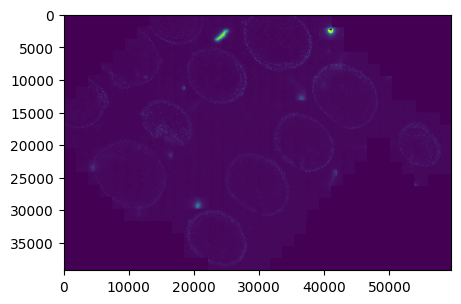

In [10]:
## Vizualise the whole slide so you choose the embrio you want to study, this step take can take few minutes
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(Cellbound2)
plt.show()


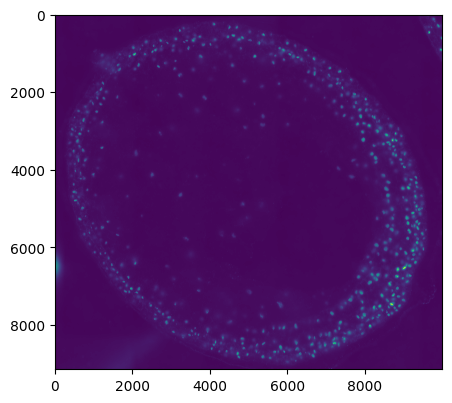

In [11]:
### select the coordinates of the ROI you want
crop_min_x = 18500
crop_max_x = 28500
crop_min_y = 4800
crop_max_y = 13950
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(Cellbound2[crop_min_y:crop_max_y,crop_min_x:crop_max_x])
plt.show()

In [ ]:
#### save the cropped images
path_tiff_folder = Path(path_to_region + "/images")
for path_tiff in tqdm(list(path_tiff_folder.glob("*.tif"))):
    try : 
        tiff = tifffile.imread(path_tiff)
        tifffile.imwrite(Path(path_to_save_crop_img) / path_tiff.name, tiff[crop_min_y:crop_max_y,crop_min_x:crop_max_x])
    except:
        print(f"{path_tiff.name} where not save")
        pass

  3%|██████▊                                                                                                                                                                                             | 1/29 [00:14<06:48, 14.58s/it]

mosaic_Cellbound1_z0.tif where not save


  7%|█████████████▌                                                                                                                                                                                      | 2/29 [00:28<06:26, 14.32s/it]

mosaic_Cellbound1_z1.tif where not save


 10%|████████████████████▎                                                                                                                                                                               | 3/29 [00:40<05:38, 13.01s/it]

mosaic_Cellbound1_z2.tif where not save


 17%|█████████████████████████████████▊                                                                                                                                                                  | 5/29 [01:11<05:46, 14.45s/it]

In [5]:
# save the cropped ROI with the corresponding RNA and cell coordinates csv
limx = crop_max_x - crop_min_x
limy = crop_max_y - crop_min_y

for path_csv  in tqdm(list(Path(path_to_save_csv_rna).glob("*z*.csv"))):
    csv = pd.read_csv(path_csv)
    print(csv.shape)
    csv["global_x"] = csv["global_x"] - crop_min_x * 0.108
    csv["global_y"] = csv["global_y"] - crop_min_y * 0.108
    csv = csv[np.logical_and(np.logical_and(csv["global_x"] > 0, csv["global_y"] > 0),
                             np.logical_and(csv["global_x"] < limx * 0.108 , csv["global_y"] < limy * 0.108) ) ]
    print(csv.shape)
    print()
    csv.to_csv(Path(path_to_save_crop_csv) / path_csv.name, index=False)

## save cropped cell_metadata
csv_cell = pd.read_csv(path_to_save_csv_rna + "/cell_metadata.csv")
csv_cell["center_x"] = csv_cell["center_x"] - crop_min_x
csv_cell["center_y"] = csv_cell["center_y"] - crop_min_y
csv_cell.to_csv(Path(path_to_save_crop_csv) / f"cell_metadata.csv", index=False)


  0%|                                                                                                                                                                                                             | 0/8 [00:00<?, ?it/s]

(1562364, 11)
(164272, 11)



 12%|████████████████████████▋                                                                                                                                                                            | 1/8 [00:02<00:17,  2.53s/it]

(1745837, 11)
(180570, 11)



 25%|█████████████████████████████████████████████████▎                                                                                                                                                   | 2/8 [00:05<00:15,  2.63s/it]

(1928940, 11)
(195215, 11)



 38%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 3/8 [00:08<00:14,  2.81s/it]

(2011165, 11)
(199226, 11)



 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 4/8 [00:11<00:11,  2.96s/it]

(1964229, 11)
(189501, 11)



 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 5/8 [00:14<00:09,  3.01s/it]

(1785891, 11)
(171679, 11)



 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 6/8 [00:17<00:05,  2.92s/it]

(1569245, 11)
(151397, 11)



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 7/8 [00:19<00:02,  2.72s/it]

(12567671, 11)
(1251860, 11)



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:43<00:00,  5.46s/it]


## Test segmentation
you can test if segmentation works with a default pre-trained netwok, if this step is too long you can run test only on tiles images (next step)

The segmentation is performed with cellpose, you can try many different parameters : https://cellpose.readthedocs.io/en/latest/settings.html

In [5]:
import torch
USE_GPU = torch.cuda.is_available()
print(USE_GPU)

True


In [6]:
## this step can take a mintute if USE_GPU is true, about 5 to 10 minute otherwise
## if the image is to large for your computer, use USE_GPU = False
from cellpose import models 
model = models.CellposeModel(gpu=False,
                             model_type='cyto')

print(model.gpu)

im = tifffile.imread(path_to_save_crop_img + "/mosaic_Cellbound3_z4.tif")

masks, flows, styles = model.eval(im,
                                     diameter=90,
                                     channels=[0, 0],
                                     flow_threshold=0.4,
                                     do_3D=False,
                                     stitch_threshold=0)

path_to_save_segmentation = path_to_save_crop + "/segmentation"
Path(path_to_save_segmentation).mkdir(parents=True, exist_ok=True)

tifffile.imwrite(Path(path_to_save_segmentation) / "segmentation.tif", data=masks, dtype=masks.dtype)
tifffile.imwrite(Path(path_to_save_segmentation) / "segmentation_binary.tif", data=np.array(masks > 0).astype(masks.dtype) , dtype=masks.dtype)

False


Use ``segmentation_binary.tif`` to vizualised it in the tissuumap

<img src="img_notebook/seg1.png" alt="drawing" width="50%"/>

## Annotate few tiles to retrain the model.
To improve the perfomance of the model, you need to annotate some cells yourself on few tiles so the model can be'retrained' on these good examples  

the first step is crop some tiles (small images) so you can annotate in the cellpose graphical user interface (GUI)

In [14]:
##crop some tiles

### load the Z stack / cellbound you want to tile
im = tifffile.imread(path_to_save_crop_img + "/mosaic_Cellbound3_z4.tif")

## set the tilling dimmension, here a 10x10 grid
M = im.shape[0] // 10
N = im.shape[1] // 10

tiles = [{str(x)+'_'+str(y) :  im[x:x + M, y:y + N]} for x in range(0, im.shape[0], M) for y in range(0, im.shape[1], N)]

## save the tiles for latter used
path_to_save_crop_tiles = path_to_save_crop_img + '/mosaic_Cellbound3_z4'
Path(path_to_save_crop_tiles).mkdir(parents=True, exist_ok=True)

for t in tiles:
    for k in t:
        tifffile.imwrite(Path(path_to_save_crop_tiles) / (k +'.tif'), t[k])
        

Then you can use the cellpose GUI to annotate and re-train your model.  
If not already, install cellpose GUI by doing ``python -m pip install cellpose[gui]`` in a terminal

lunch it with ``python -m cellpose`` in a terminal and follow the guideline here: https://cellpose.readthedocs.io/en/latest/gui.html

<img src="img_notebook/annotation.png" alt="drawing" width="50%"/>

## Re-apply the segmentation
Once the result are good in the gui, you can re-apply the re-trained cellpose on your cropped ROI.
The re-trained model is a file in the tiles folder. You need to complete the argument ``pretrained_model``  
Of note it is better to use the `` diameter`` used for the training and do not use a too small diameter for memory issue.

In [17]:
USE_GPU =False
## to complete with your path 
pretrained_model = "/media/tom/Transcend/bioinfo-portal.curie.fr/backend/services/popeye/2018383/output/region_1/crop2/images/mosaic_Cellbound3_z4/models/CP_chenxi"
model = models.CellposeModel(gpu=USE_GPU,
                             
                             pretrained_model = pretrained_model)

print(model.gpu)
                    #    pretrained_model='/media/tom/Transcend/bioinfo-portal.curie.fr/backend/services/popeye/2018383/output/region_1/crop_7200_18000_37500_48500/retraining_DAPI/models/TN2_DAPIeee')
im = tifffile.imread(path_to_save_crop_img + "/mosaic_Cellbound3_z4.tif")

masks, flows, styles = model.eval(im,
                                     diameter=118,
                                     channels=[0, 0],
                                     flow_threshold=0.4,
                                     stitch_threshold=0)

path_to_save_segmentation = path_to_save_crop + "/segmentation"
Path(path_to_save_segmentation).mkdir(parents=True, exist_ok=True)

tifffile.imwrite(Path(path_to_save_segmentation) / "segmentation_retrained.tif", data=masks, dtype=masks.dtype)
tifffile.imwrite(Path(path_to_save_segmentation) / "segmentation_retrained_binary.tif", data=np.array(masks > 0).astype(masks.dtype) , dtype=masks.dtype)

False


<img src="img_notebook/retrained.png" alt="drawing" width="50%"/>

Here the segmentation is not really good. It might be better with more annotation.